# Введение в цифровую обработку сигналов и использование диффузионных моделей в аудио-домене

In [ ]:
!pip install git+https://github.com/declare-lab/TangoFlux

  Cloning https://github.com/declare-lab/TangoFlux to /tmp/pip-req-build-vsxn9wmd
  Running command git clone --filter=blob:none --quiet https://github.com/declare-lab/TangoFlux /tmp/pip-req-build-vsxn9wmd
  Resolved https://github.com/declare-lab/TangoFlux to commit 02b48d4ab6c532203e9aed1687e6cc2a52b6dffb
  Preparing metadata (setup.py) ... done


In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import argparse
import torchaudio
import torch
import numpy as np
from tangoflux import TangoFluxInference
from tqdm import tqdm
from diffusers import FlowMatchEulerDiscreteScheduler

## Часть 1: Анализируем речь и отрисовываем волну

Освоим отрисовку формы волны звука на языке Python.

Загружаем файл: /content/p shu a.m4a


<ipython-input-13-c0726420e381>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(str(audio_path), sr=SAMPLE_RATE)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


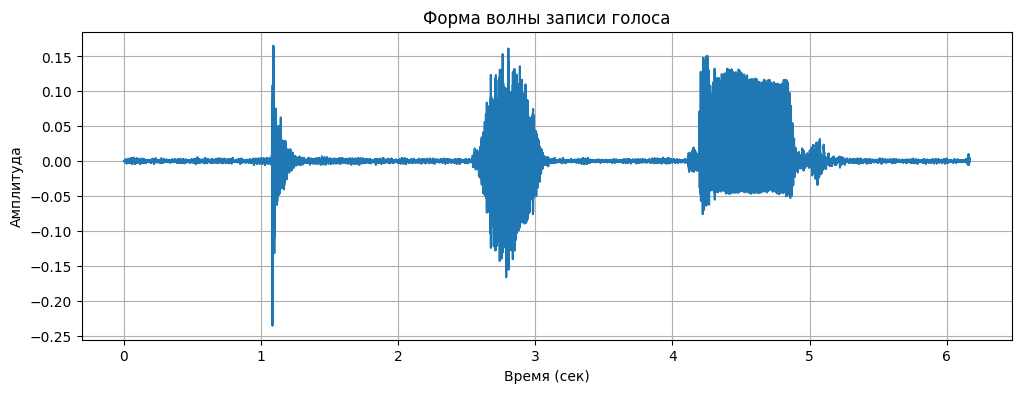

In [ ]:
audio_path = Path("p shu a.m4a").absolute()
print(f"Загружаем файл: {audio_path}")
y, sr = librosa.load(str(audio_path), sr=SAMPLE_RATE)

plt.figure(figsize=(12, 4))
plt.plot(np.linspace(0, len(y)/sr, len(y)), y)
plt.title('Форма волны записи голоса')
plt.xlabel('Время (сек)')
plt.ylabel('Амплитуда')
plt.grid(True)
plt.show()


## Часть 2: Получаем БПФ временного ряда целиком

Дополнительный материал: горячо рекомендую научно-познавательное видео 3blue1brown о преобразовании Фурье, доступны субтитры на русском: https://youtu.be/spUNpyF58BY?si=DUJrrcj1KQ4W59j6

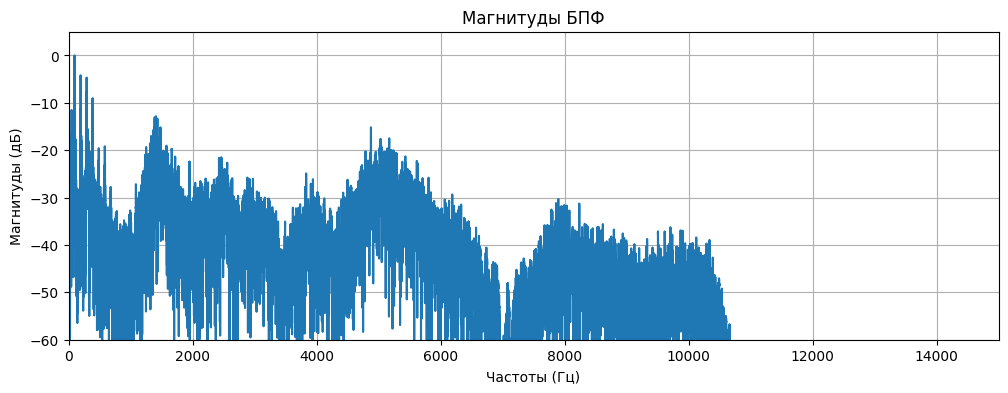

In [ ]:
# Используем сигнал целиком
window = np.hanning(len(y))
windowed_signal = y * window # Здесь это условность, но именно так мы делаем при получении БПФ сигнала

# Вычисляем БПФ и преобразуем в шкалу децибел
fft_result = np.fft.rfft(windowed_signal)
fft_freq = np.fft.rfftfreq(len(y), 1/sr)
magnitude_spectrum = np.abs(fft_result)
magnitude_db = 20 * np.log10(magnitude_spectrum / np.max(magnitude_spectrum))

plt.figure(figsize=(12, 4))
plt.plot(fft_freq, magnitude_db)
plt.title('Магнитуды БПФ')
plt.xlabel('Частоты (Гц)')
plt.ylabel('Магнитуды (дБ)')
plt.grid(True)
plt.xlim(0, 15000)  # Для студентов: Какие частоты наиболее актуальны для голоса
plt.ylim(-60, 5)   # Разумный диапазон децибел
plt.show()

## Часть 2: Строим спектрограмму с помощью БПФ временного ряда

Быстрое преобразование фурье к временному ряду применяется с оконной функцией. Меняя параметр размера окна, мы увидим различия в АЧХ. Если в прошлой ячейке мы это делали условно, то сейчас оконная функция применяется к каждому блоку сигнала отдельно, благодаря чему мы видим спектрограмму без искажений частот.

fft_window.svg

Processing Cell 3: Spectrogram Analysis


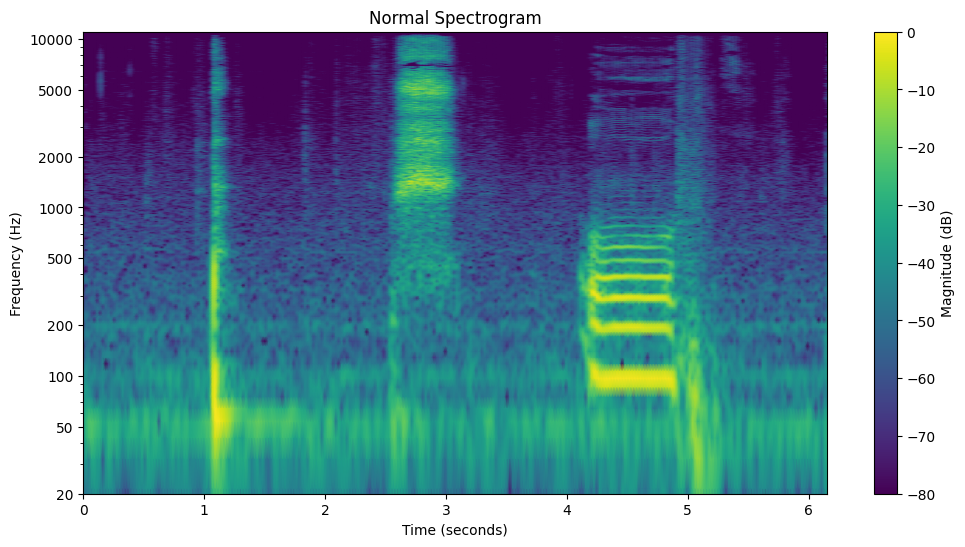

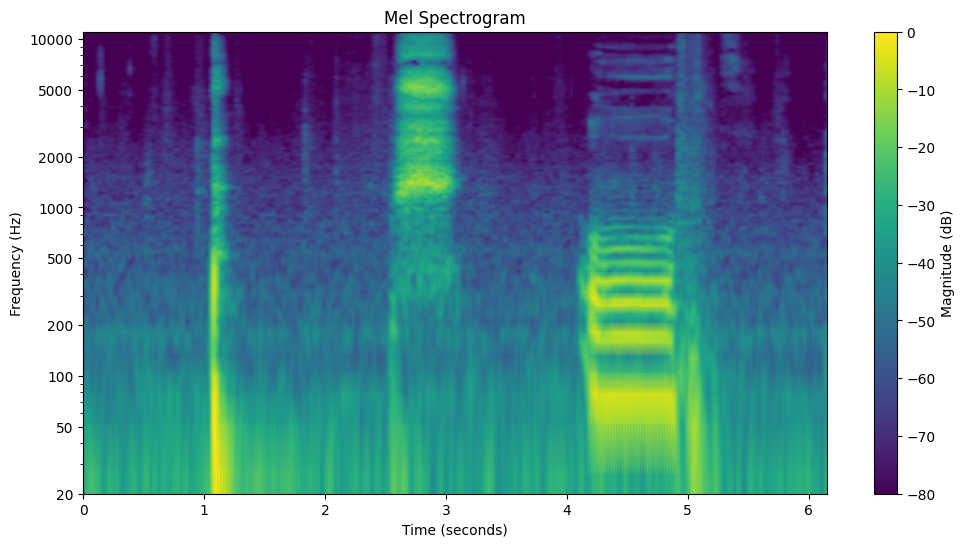

In [ ]:
# Константы для построения спектрограммы
SAMPLE_RATE = 22050  # Частота сэмплирования
N_FFT = 2048         # Окно БПФ
HOP_LENGTH = 512     # Количество сэмплов, обрабатываемых за один проход
N_MELS = 128         # Number of mel bands
DB_SCALE = True      # Whether to convert to decibels

# Функция, облегчающая форматирование отметок по горизонтальной оси
def format_freq_ticks(ax):
    # Определим ряд частот, которые мы хотим отметить
    freq_ticks = [20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
    ax.set_yticks(freq_ticks)
    ax.set_yticklabels([f'{f:g}' for f in freq_ticks])  # :g removes trailing zeros


# Вычисляем STFT
D = librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH, window='hann')
magnitude = np.abs(D)

# Устанавливаем оси времени и частоты
times = librosa.times_like(magnitude, sr=sr, hop_length=HOP_LENGTH)
freqs = librosa.fft_frequencies(sr=sr, n_fft=N_FFT)

# Часть 1: обыкновенная спектрограмма
plt.figure(figsize=(12, 6))
magnitude_db = librosa.amplitude_to_db(magnitude, ref=np.max)
plt.pcolormesh(times, freqs, magnitude_db, shading='gouraud', vmin=-80, vmax=0)
plt.colorbar(label='Магнитуда (дб)')
plt.title('Обыкновенная спектрограмма')
plt.xlabel('Время (сек)')
plt.ylabel('Частота (Гц)')
plt.yscale('log')
plt.ylim(20, sr/2)
format_freq_ticks(plt.gca())
plt.show()

# Part 2: Конвертируем в мел-спектрограмму
# 1. Создаём мел-фильтрбанк
mel_basis = librosa.filters.mel(sr=sr, n_fft=N_FFT, n_mels=N_MELS)
# 2. Применяем мел-фильтрбанк для получения мел-спектрограммы
mel_spectrogram = np.dot(mel_basis, magnitude)
# 3. Получаем мел-частоты для оси Y
mel_freqs = librosa.mel_frequencies(n_mels=N_MELS, fmin=0, fmax=sr/2)
# 4. Конвертируем в шкалу дБ (так же, как мы сделали с нормальной спектрограммой)
mel_db = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)

# 5. Отрисовываем мел-спектрограмму
plt.figure(figsize=(12, 6))
plt.pcolormesh(times, mel_freqs, mel_db, shading='gouraud', vmin=-80, vmax=0)
plt.colorbar(label='Магнитуда (дб)')
plt.title('Мел-спектрограмма')
plt.xlabel('Время (сек)')
plt.ylabel('Частота (Гц)')
plt.yscale('log')
plt.ylim(20, sr/2)
format_freq_ticks(plt.gca())
plt.show('cell_3b_output.png')

Мел-шкала частот следует логарифмической кривой, эмпирически соответствующей человеческому слуху.

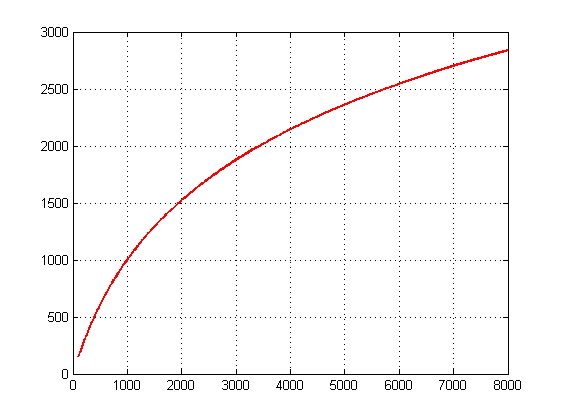

## Часть 3: Flow matching в задаче text2audio - нейросеть TangoFlux

[https://github.com/declare-lab/TangoFlux](https://github.com/declare-lab/TangoFlux)

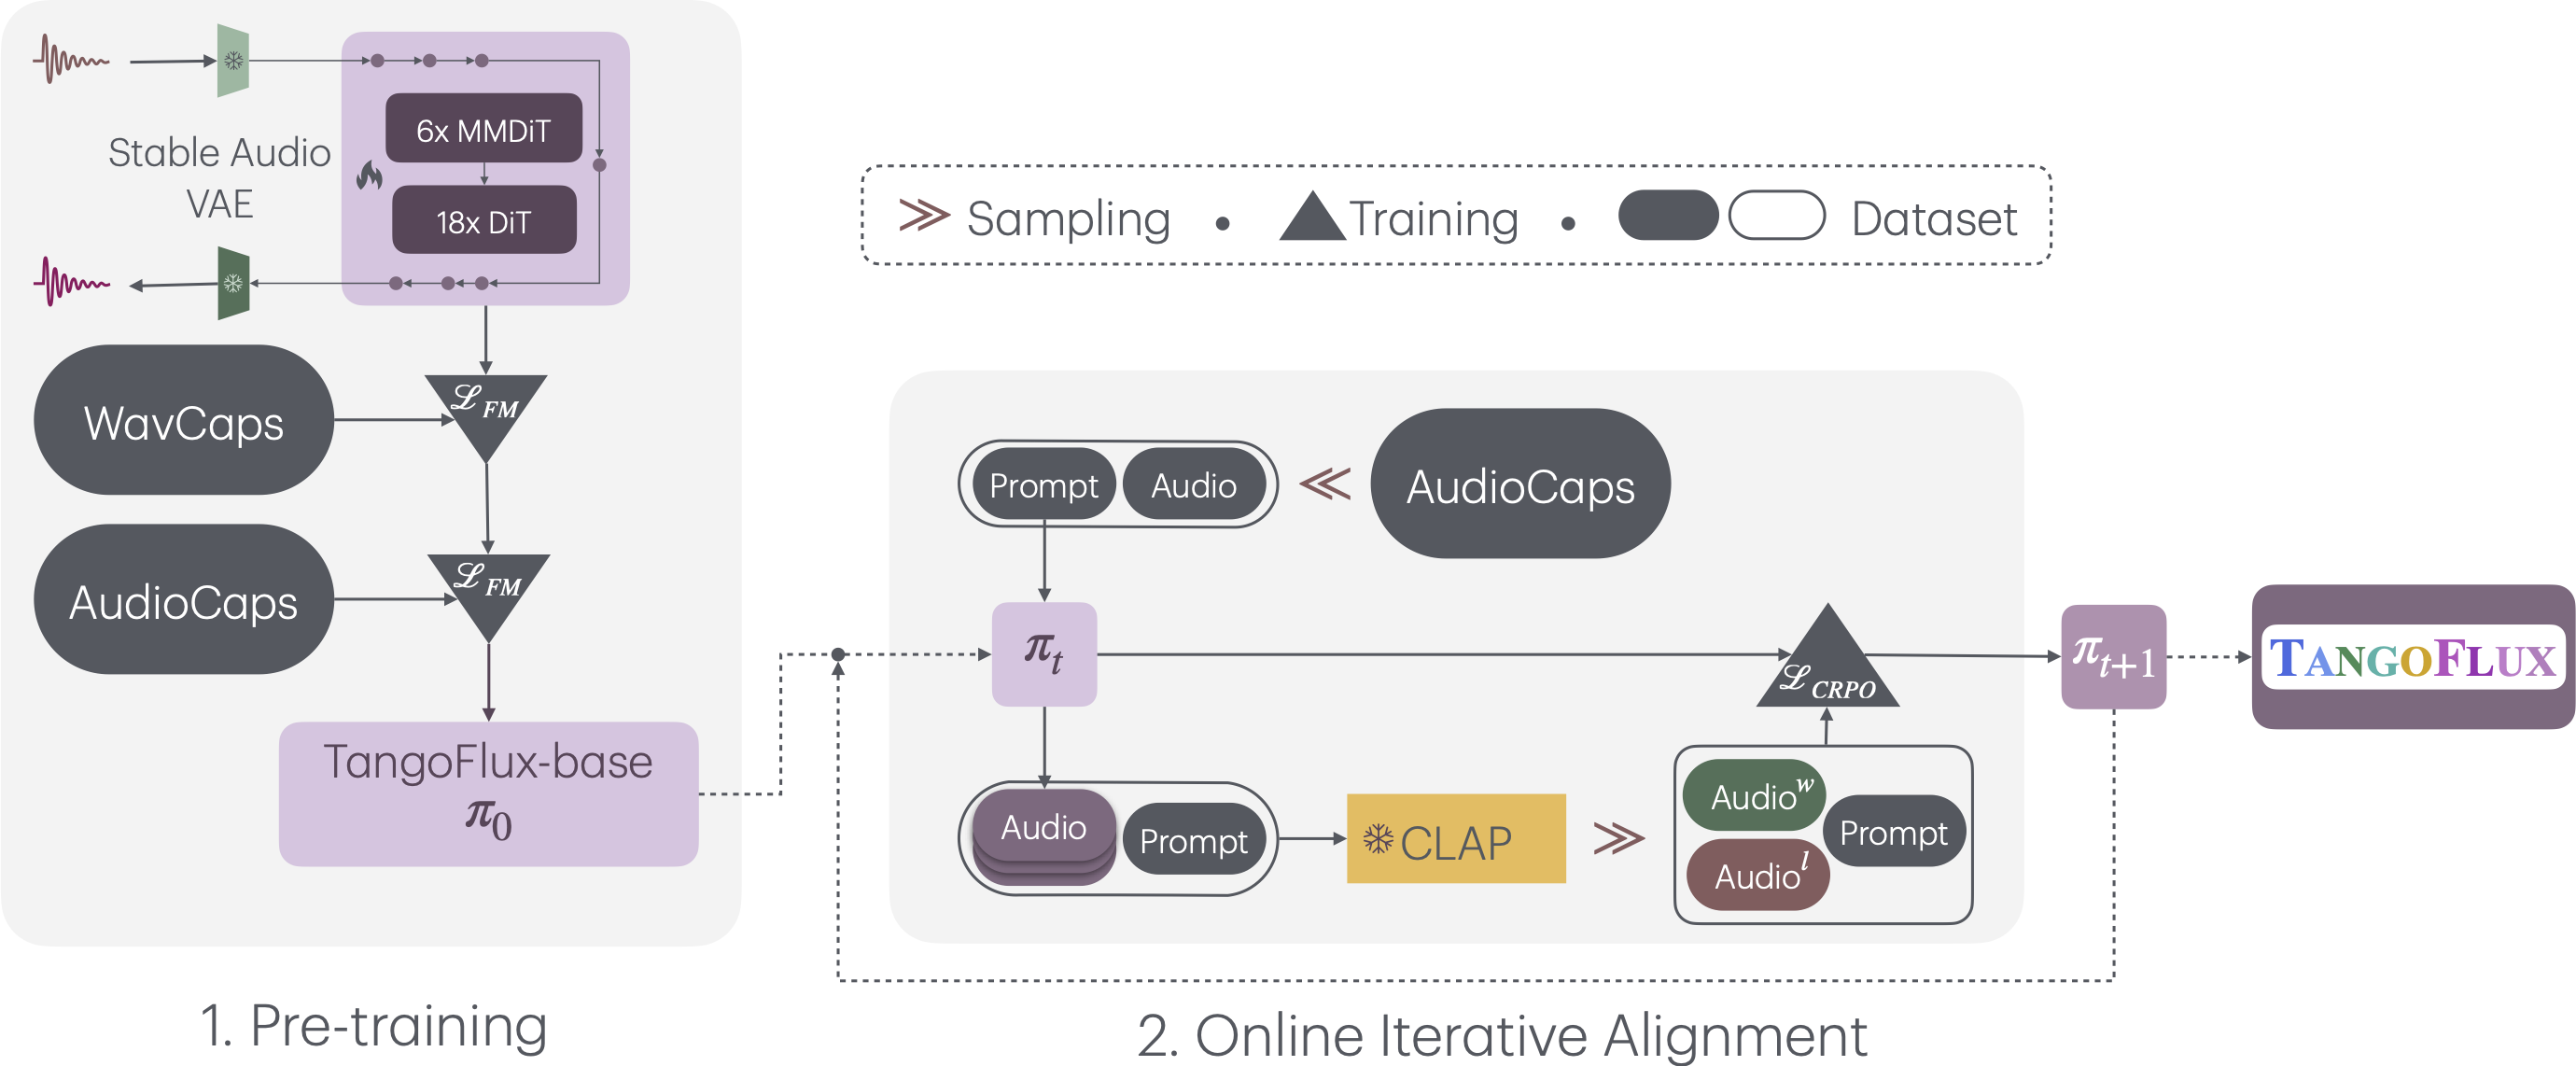

In [ ]:
import torch
import torchaudio
import numpy as np
from tqdm import tqdm
from diffusers import FlowMatchEulerDiscreteScheduler
from tangoflux import TangoFluxInference
import ipywidgets as widgets
from IPython.display import display, Audio

def retrieve_timesteps(scheduler, num_inference_steps, device, timesteps=None, sigmas=None):
    scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = scheduler.timesteps
    return timesteps, num_inference_steps

def generate_audio(prompt, duration=10, steps=50, guidance_scale=4.5, output='output.wav'):
    # Проверяем длительность
    if not 1 <= duration <= 30:
        raise ValueError("Длина должна быть между 1 и 30 секундами")

    # Устанавливаем устройство
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    if device.startswith("cuda"):
        torch.cuda.set_device(0)

    model = TangoFluxInference(name='declare-lab/TangoFlux', device=device)

    print(f"Генерируем аудио с промптом: '{prompt}'")
    print(f"Длина: {duration}s, Кол-во шагов: {steps}, Сила гайденса: {guidance_scale}")

    # Процесс flow matching
    with torch.no_grad():
        num_inference_steps = steps
        guidance = guidance_scale
        num_samples_per_prompt = 1

        # Преобразуем входы в нужный формат
        prompt_list = prompt if isinstance(prompt, list) else [prompt]
        duration_tensor = torch.tensor([duration], device=device)

        # Определяем, нужно ли использовать CFG
        classifier_free_guidance = guidance > 1.0

        # Получаем длительность генерации
        duration_hidden_states = model.model.encode_duration(duration_tensor)

        # В зависимости от того, используется ли CFG, кодируем промпт в нужный вид
        if classifier_free_guidance:
            bsz = 2 * num_samples_per_prompt
            encoder_hidden_states, boolean_encoder_mask = model.model.encode_text_classifier_free(
                prompt_list, num_samples_per_prompt=num_samples_per_prompt
            )
            duration_hidden_states = duration_hidden_states.repeat(bsz, 1, 1)
        else:
            bsz = num_samples_per_prompt
            encoder_hidden_states, boolean_encoder_mask = model.model.encode_text(
                prompt_list, num_samples_per_prompt=num_samples_per_prompt
            )

        # Обрабатываем текстовые эмбеддинги
        mask_expanded = boolean_encoder_mask.unsqueeze(-1).expand_as(encoder_hidden_states)
        masked_data = torch.where(mask_expanded, encoder_hidden_states, torch.tensor(float("nan")))
        pooled = torch.nanmean(masked_data, dim=1)
        pooled_projection = model.model.fc(pooled)

        # Объединяем текст и эмбеддинги длины генерации
        encoder_hidden_states = torch.cat([encoder_hidden_states, duration_hidden_states], dim=1)

        # Настраиваем шедулер
        scheduler = model.model.noise_scheduler
        sigmas = np.linspace(1.0, 1 / num_inference_steps, num_inference_steps)
        timesteps, num_inference_steps = retrieve_timesteps(scheduler, num_inference_steps, device, sigmas=sigmas)

        # Инициализируем латентную переменную
        latents = torch.randn(num_samples_per_prompt, model.model.audio_seq_len, 64, device=device)

        # Настраиваем ID положений
        txt_ids = torch.zeros(bsz, encoder_hidden_states.shape[1], 3, device=device)
        audio_ids = (
            torch.arange(model.model.audio_seq_len)
            .unsqueeze(0)
            .unsqueeze(-1)
            .repeat(bsz, 1, 3)
            .to(device)
        )

        # Убеждаемся, что тензоры на том устройстве, на котором им положено
        timesteps = timesteps.to(device)
        encoder_hidden_states = encoder_hidden_states.to(device)

        # Цикл денойзинга
        progress_bar = tqdm(range(num_inference_steps))
        for i, t in enumerate(timesteps):
            # Подгатавливаем ввод
            latents_input = torch.cat([latents] * 2) if classifier_free_guidance else latents

            # Предсказываем шум
            noise_pred = model.model.transformer(
                hidden_states=latents_input,
                timestep=torch.tensor([t / 1000], device=device),
                guidance=None,
                pooled_projections=pooled_projection,
                encoder_hidden_states=encoder_hidden_states,
                txt_ids=txt_ids,
                img_ids=audio_ids,
                return_dict=False,
            )[0]

            # Применяем CFG
            if classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance * (noise_pred_text - noise_pred_uncond)

            # Шаг шедулера
            latents = scheduler.step(noise_pred, t, latents).prev_sample
            progress_bar.update(1)

        # Декодируем латент в аудио
        wave = model.vae.decode(latents.transpose(2, 1)).sample.cpu()[0]
        waveform_end = int(duration * 44100)  # 44100 is the sampling rate
        wave = wave[:, :waveform_end]

    print(f"Сохраняем аудио в файл: {output}")
    torchaudio.save(output, wave, 44100)
    print("Готово!")

    # Показываем аудиоплеер в ноутбуке
    display(Audio(output, rate=44100))

# UI виджетов для Колаба
prompt_widget = widgets.Text(value='A sound of ocean waves', description='Промпт:')
duration_widget = widgets.IntSlider(value=10, min=1, max=30, description='Длина (сек):')
steps_widget = widgets.IntSlider(value=50, min=1, max=100, description='Кол-во шагов:')
guidance_widget = widgets.FloatSlider(value=4.5, min=1.0, max=10.0, step=0.1, description='Сила CFG:')
output_widget = widgets.Text(value='output.wav', description='Название выходного файла:')

generate_button = widgets.Button(description="Сгенерировать аудио", button_style='success')

def on_generate_clicked(b):
    # Читаем параметры с UI виджетов
    prompt = prompt_widget.value
    duration = duration_widget.value
    steps = steps_widget.value
    guidance_scale = guidance_widget.value
    output = output_widget.value
    generate_audio(prompt, duration, steps, guidance_scale, output)

generate_button.on_click(on_generate_clicked)

# Показываем UI
display(prompt_widget, duration_widget, steps_widget, guidance_widget, output_widget, generate_button)

Text(value='A sound of ocean waves', description='Промпт:')

IntSlider(value=10, description='Длина (сек):', max=30, min=1)

IntSlider(value=50, description='Кол-во шагов:', min=1)

FloatSlider(value=4.5, description='Сила CFG:', max=10.0, min=1.0)

Text(value='output.wav', description='Название выходного файла:')

Button(button_style='success', description='Сгенерировать аудио', style=ButtonStyle())

## Часть 4: Перенос стиля в TangoFlux - частичный денойзинг

In [ ]:
import os
import torch
import torchaudio
import numpy as np
import gc
import ipywidgets as widgets
from IPython.display import display, Audio

from tangoflux import TangoFluxInference
from diffusers import FlowMatchEulerDiscreteScheduler

def print_audio_stats(name, audio):
    if isinstance(audio, torch.Tensor):
        print(f"{name} shape: {audio.shape}, range: [{audio.min():.3f}, {audio.max():.3f}]")
    else:
        print(f"{name} type: {type(audio)}")

def generate_audio2audio(prompt, input_audio_path, strength=0.5, duration=10, steps=50, output='output.wav'):
    # Валидируем параметры
    if not 0.0 <= strength <= 1.0:
        raise ValueError("Степень смешения должна лежать между 0.0 и 1.0")
    if not 1 <= duration <= 30:
        raise ValueError("Длина должна быть между 1 и 30 секундами")

    # Устанавливаем устройство
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    if torch.cuda.is_available():
        print(f"Используем GPU: {torch.cuda.get_device_name(device)}")
    else:
        print("Осторожно! Используем CPU. Будет медленно!")

    print("Загрузка модели")
    model = TangoFluxInference(name='declare-lab/TangoFlux')

    # Загружаем и обрабатываем входное аудио
    waveform, sample_rate = torchaudio.load(input_audio_path)
    print_audio_stats("Оригинальная форма волны", waveform)

    # Ресэмплируем, если необходимо
    if sample_rate != 44100:
        resampler = torchaudio.transforms.Resample(sample_rate, 44100)
        waveform = resampler(waveform)
        print_audio_stats("Волна ресэмплирована", waveform)

    # Вычисляем целевую длину генерации и размер тензора на входе в VAE
    target_length = int(44100 * duration)  # длина в сэмплах
    vae_downsample_factor = 2048           # VAE делает даунсэмплинг в такой пропорции
    model_latent_length = 645              # expected latent length of the model
    vae_target_length = model_latent_length * vae_downsample_factor

    # Обрабатываем входное аудио, чтобы получить тензор длины, ожидаемой VAE
    if waveform.size(1) > vae_target_length:
        waveform = waveform[:, :vae_target_length]
    else:
        waveform = torch.nn.functional.pad(waveform, (0, vae_target_length - waveform.size(1)))
    print_audio_stats("Волна с паддингом", waveform)

    # Проверяем, что сигнал в стерео
    if waveform.size(0) == 1:
        waveform = waveform.repeat(2, 1)
    elif waveform.size(0) > 2:
        waveform = waveform[:2]
    print_audio_stats("Final input waveform", waveform)

    # Перемещаем модель на устройство
    device = model.vae.device
    waveform = waveform.to(device)

    # Устанавливаем случайный сид
    torch.manual_seed(0)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(0)

    # Кодируем аудио в латентное пространство
    with torch.no_grad():
        latents = model.vae.encode(waveform.unsqueeze(0)).latent_dist.sample()

        # Model expects latents in shape [B, L, C]
        latents = latents.permute(0, 2, 1)

    print(f"Генерируем аудио с промптом: '{prompt}'")
    print(f"Используя силу CFG: {strength}")
    with torch.no_grad():
        # Для силы=0, возвращаем закодированные латенты
        if strength == 0.0:
            output_latents = latents
        # Для силы=1 полностью генерируем звук
        elif strength == 1.0:
            output_latents = model.model.inference_flow(
                prompt,
                num_inference_steps=steps,
                duration=duration,
                seed=0,
                disable_progress=False
            )
        else:
            # Генерируем шум и интерполируем между оригинальными и полностью сгенерированными латентами
            noise = torch.randn_like(latents)
            noised_latents = (1.0 - strength) * latents + strength * noise
            generated_latents = model.model.inference_flow(
                prompt,
                num_inference_steps=steps,
                duration=duration,
                seed=0,
                disable_progress=False
            )
            output_latents = (1.0 - strength) * noised_latents + strength * generated_latents


        # Декодируем в звук
        wave = model.vae.decode(output_latents.transpose(1, 2)).sample.cpu()[0]

    waveform_end = int(duration * 44100)
    wave = wave[:, :waveform_end]

    print(f"Сохраняем звук: {output}")
    torchaudio.save(output, wave, 44100)
    print("Готово!")
    display(Audio(output, rate=44100))

prompt_widget = widgets.Text(value='A sound of a jungle at night', description='Промпт:')
strength_widget = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.05, description='Сила CFG:')
duration_widget = widgets.IntSlider(value=10, min=1, max=30, description='Длин (сек):')
steps_widget = widgets.IntSlider(value=50, min=1, max=100, description='Количество шагов:')
output_widget = widgets.Text(value='output.wav', description='Выходной файл:')

# Виджет для загрузки файлов (настроен только на .wav)
input_audio_widget = widgets.FileUpload(accept='.wav', multiple=False, description='Входное аудио')

generate_button = widgets.Button(description="Генерируем audio2audio", button_style='success')

def on_generate_clicked(b):
    # Сохраняем загруженный файл
    if input_audio_widget.value:
        for fname, file_info in input_audio_widget.value.items():
            input_file_path = fname
            with open(input_file_path, 'wb') as f:
                f.write(file_info['content'])
            break
    else:
        input_file_path = 'output1.wav'
        print(f"Файл не загружен. Используем файл по умолчанию: {input_file_path}")

    prompt = prompt_widget.value
    strength = strength_widget.value
    duration = duration_widget.value
    steps = steps_widget.value
    output = output_widget.value

    generate_audio2audio(prompt, input_file_path, strength, duration, steps, output)

generate_button.on_click(on_generate_clicked)

display(prompt_widget, strength_widget, duration_widget, steps_widget, output_widget, input_audio_widget, generate_button)

Text(value='A sound of a jungle at night', description='Prompt:')

FloatSlider(value=0.5, description='Strength:', max=1.0, step=0.05)

IntSlider(value=10, description='Duration (s):', max=30, min=1)

IntSlider(value=50, description='Steps:', min=1)

Text(value='output.wav', description='Output File:')

FileUpload(value={}, accept='.wav', description='Input Audio')

Button(button_style='success', description='Generate Audio2Audio', style=ButtonStyle())

Используем GPU: Tesla T4



/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loading input audio: p_shu_a.wav
Original waveform shape: torch.Size([1, 295936]), range: [-0.236, 0.164]
Resampled waveform shape: torch.Size([1, 271892]), range: [-0.237, 0.166]
Padded waveform shape: torch.Size([1, 1320960]), range: [-0.237, 0.166]
Final input waveform shape: torch.Size([2, 1320960]), range: [-0.237, 0.166]
Encoding input audio to latent space...
VAE encoded latents shape: torch.Size([1, 64, 645]), range: [-4.407, 3.977]
Permuted latents shape: torch.Size([1, 645, 64]), range: [-4.407, 3.977]
Generating audio with prompt: 'Sound of drums'
Using strength: 0.5


100%|██████████| 50/50 [00:16<00:00,  2.94it/s]


Output latents shape: torch.Size([1, 645, 64]), range: [-3.415, 2.608]
Decoded wave shape: torch.Size([2, 1320960]), range: [-0.430, 0.413]
Final output wave shape: torch.Size([2, 441000]), range: [-0.430, 0.413]
Saving audio to: output2.wav
Done!


# Спасибо за внимание!